In [90]:
import numpy
import scipy
import scipy.optimize
import scipy.integrate
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.signal
import sympy as sp
import pandas as pd
import tbcontrol.responses
from collections import deque
%matplotlib inline
mpl.rcParams['font.serif'] ="Cambria"
mpl.rcParams['font.family'] ="serif"
mpl.rcParams['font.size']="22"

#plt.rc('text', usetex=True )
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

# System description and diagram

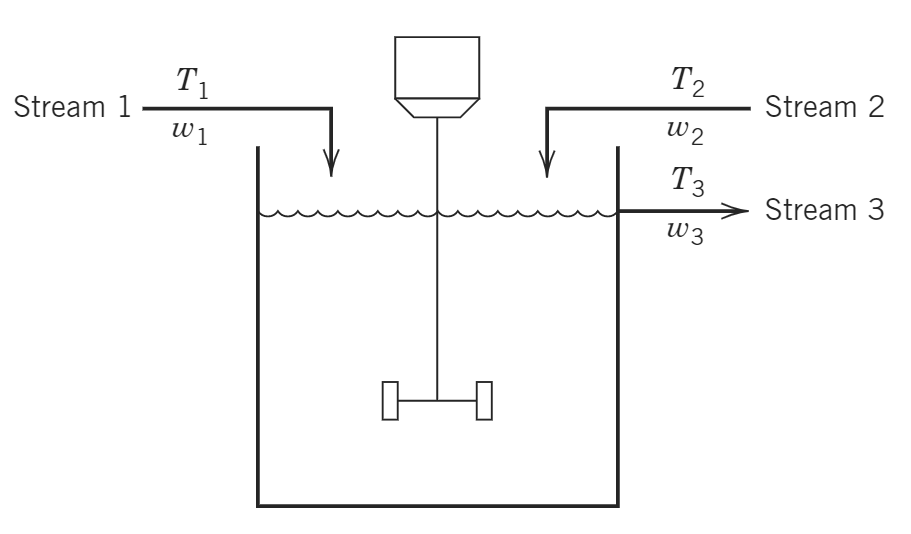

A perfectly stirred, constant-volume tank has two input streams, both consisting of the same liquid. It is known that the temperature of stream 1, T$_{1}$ is constant while the inlet flowrate w$_{1}$, can vary with time by manipulation of the stream using a control valve. The second inlet stream, stream 2, is known to have a constant flowrate, w$_{2}$, with variances in temperature. The goal of the process is to control the outlet temperature T$_{3}$ of stream 3. <br> 

# Model equations

Since the tank is constant volume and the both inlets are the same liquid it is assumed that density and heat capacity does not vary much over the temperature ranges that will be observed in this system. This simplifies the mass and energy balance to the following equations

## Model
\begin{align}
w_{3} &= w_{1} + w_{2} \\
V\rho\frac{\mathrm{d}T_{3}}{\mathrm{d}t} &= w_{1} T_{1} + w_{2} T_{2} - w_{3} T_{3} \\
\end{align}

# Parameters

In [2]:
T1 = 300
ρ = 1000 #kg/m3
V = 1 #m3
w2 = 2 #kg/s
T1 = 300#K
T3bar = 340

In [3]:
x0 = numpy.array([T3bar])

# Inputs 

In [4]:
def MV_w1(t): # this is your manipulated variable 
    
    if t < 0:
        return 3
    
    if t >= 0:
        return 3
    
def DV_T2(t): # this is your disturbance variable 
    
    if t < 0:
        return 400
    
    if t >= 0:
        return 400

# Model equations

In [5]:
def intsys(t,x):
    
    T3 = x
    
    w3 = MV_w1(t) + w2
    dT3dt = 1/(ρ*V)*(MV_w1(t)*T1+w2*DV_T2(t)-w3*T3)
    
    return dT3dt

In [6]:
def ss(x):
    
    return intsys(0,x)
x0 = scipy.optimize.fsolve(ss,x0)
x0

array([340.])

Now we will check if the system is at steady state 

In [7]:
ss(x0)

array([0.])

Perfect, now we can simulate 

# Time range and step size 

In [8]:
tspan = (0, 1000)
t = numpy.linspace(*tspan, 1000)

# Simulation function

In [9]:
def simulate():
    r = scipy.integrate.solve_ivp(intsys, tspan, x0, t_eval=t)
    return r.y

In [10]:
T3 = simulate()

# Plot 

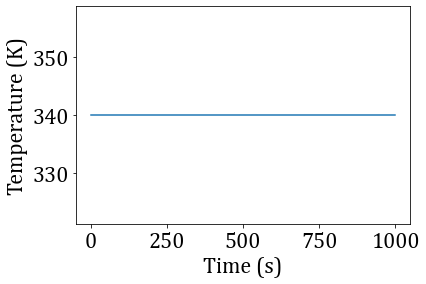

In [11]:
plt.plot(t, T3[0])


#plt.savefig(format = 'svg') save in vector format for reporting 
plt.ylabel('Temperature (K)')
plt.xlabel('Time (s)')



plt.show()

In [12]:
def MV_w1(t): # this is your manipulated variable 
    
    if t < 0:
        return 3

    if t >= 0:
        return 3
    
def DV_T2(t): # this is your disturbance variable 
    
    if t < 0:
        return 400
    
    if t >= 0:
        return 400
    
def Ysp_setpoint(t):
    
    if t<0:
        return 340
    
    if t>0:
        return 340
    
tspan = (0, 100)
t = numpy.linspace(*tspan, 100)

dt = t[1]-t[0]
system = numpy.array(x0)
results = []

for count, time in enumerate(t):
    
    
    results.append(system)
    system = system + intsys(time,results[count])*dt

In [13]:
results = numpy.array(results)

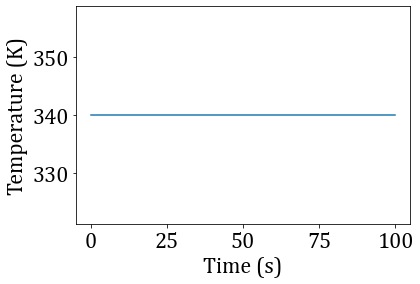

In [14]:
plt.plot(t,results)

plt.ylabel('Temperature (K)')
plt.xlabel('Time (s)')

plt.show()

# FOPDT model

In [15]:
M = 2
M

2

In [16]:
def MV_w1(t): # this is your manipulated variable 
    
    if t < 0:
        return 3
    
    if t >= 0:
        return 3 + M
    
def DV_T2(t): # this is your disturbance variable 
    
    if t < 0:
        return 400
    
    if t >= 0:
        return 400
    
def intsys(t,x):
    
    T3 = x
    
    w3 = MV_w1(t) + w2
    dT3dt = 1/(ρ*V)*(MV_w1(t)*T1+w2*DV_T2(t)-w3*T3)
    
    return dT3dt

def simulate():
    r = scipy.integrate.solve_ivp(intsys, tspan, x0, t_eval=t, max_step=0.1)
    return r.y

In [17]:
tspan = (0, 2000)
t = numpy.linspace(*tspan, 2000)

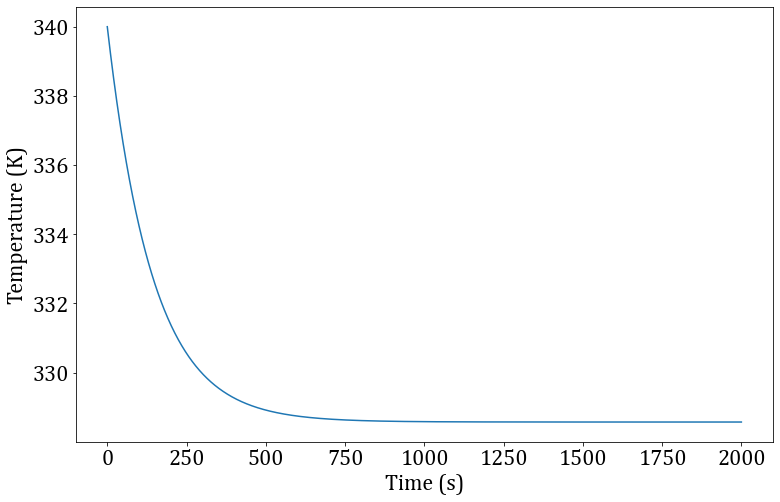

In [18]:
T3 = simulate()[0]
fig, ax1 = plt.subplots(1, 1, figsize=(25/2, 8))
ax1.set_ylabel('Temperature (K)')
ax1.set_xlabel('Time (s)')
ax1.plot(t, T3)

In [19]:
K_guess = -6
τ_guess = 200
θ_guess = 0

T3_guess = tbcontrol.responses.fopdt(t, M*K_guess, τ_guess, θ_guess) + x0[0]

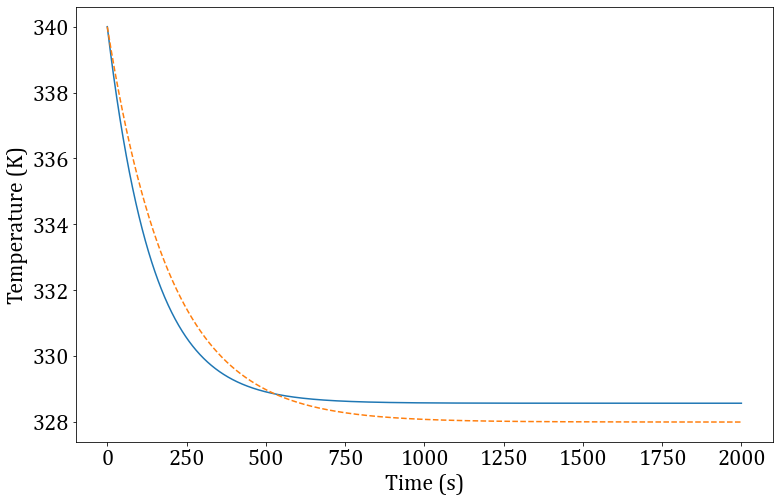

In [20]:
fig, ax1 = plt.subplots(1, 1, figsize=(25/2, 8))
ax1.set_ylabel('Temperature (K)')
ax1.set_xlabel('Time (s)')
ax1.plot(t, T3)
ax1.plot(t, T3_guess, linestyle='dashed')

In [21]:
KmM_fit, τm_fit, θm_fit = scipy.optimize.curve_fit(tbcontrol.responses.fopdt, t, T3 - x0[0], [M*K_guess, τ_guess, θ_guess])[0]
Km_fit = KmM_fit/M
T3_fit = tbcontrol.responses.fopdt(t, KmM_fit, τm_fit, θm_fit) + x0[0]

Km: -5.714285713960203, τm: 142.8571424735017, θm: 3.4287412651735744e-07


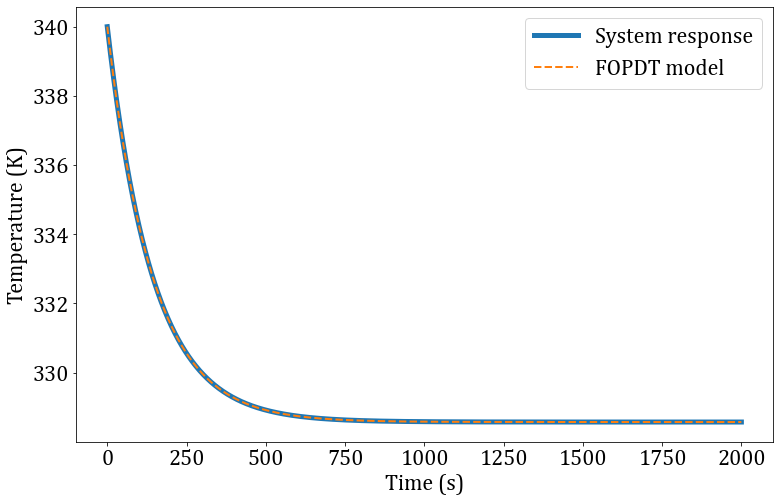

In [22]:
fig, ax1 = plt.subplots(1, 1, figsize=(25/2, 8))
ax1.set_ylabel('Temperature (K)')
ax1.set_xlabel('Time (s)')
ax1.plot(t, T3, linewidth=5, label='System response')
ax1.plot(t, T3_fit, linewidth=2, linestyle='dashed', label='FOPDT model')
ax1.legend()
print(f'Km: {Km_fit}, τm: {τm_fit}, θm: {θm_fit}')

# Tuning parameters
Cohen-Coon parameters with synthetic deadtime

In [23]:
# choose synthetic deadtime
θm = 0.1*τm_fit #

# Cohen-Coon parameters
Φ = θm/τm_fit
Kc_cc = (3*Φ + 16)/(12*Km_fit*Φ)
τi_cc = θm*(32 + 6*Φ)/(13 + 8*Φ)
τd_cc = 4*θm/(11 + 2*Φ)

# Kc_cc = -16.5
# τi_cc= 4.9
#τd_cc = 0.15
print(f'Kc_cc: {Kc_cc}, τi_cc: {τi_cc}, τd_cc: {τd_cc}')

Kc_cc: -2.3770833334687422, τi_cc: 33.7474119176533, τd_cc: 5.102040802625061


# Continuous/discrete comparison

In [24]:
def DV_T2(t): # this is your disturbance variable 
    
    if t < 0:
        return 400
    
    if t >= 0:
        return 400 + 0.05*(400) 
    
def Ysp_setpoint(t): #setpoint as a function of time 
    
    if t<0:
        return 340
    
    if t>=0:
        return 340 #+ 0.05*340
    
continuous_integration_time = 0.1

discrete_integration_time = 0.1
sampling_interval = 1

t_end = 301

## Continuous PID

In [25]:
# PID as a rational polynomial
sp.var('Kc, τi, τd, α, s')
Gc_pid = Kc*(1 + 1/(τi*s) + τd*s/(α*τd*s + 1))
Gc_pid.factor()

Kc*(s**2*α*τd*τi + s**2*τd*τi + s*α*τd + s*τi + 1)/(s*τi*(s*α*τd + 1))

In [26]:
α = (0.05 + 0.2)/2
t = numpy.arange(0, t_end, continuous_integration_time) #adjust for sampling 
α

0.125

In [27]:
def cont_controller(Kc, Taui, Taud, α):
    #Gc = scipy.signal.lti([Kc*Taui,Kc],[Taui,0]).to_ss() #conversion to state space from laplace domain
    Gc = scipy.signal.lti([Kc*Taui*Taud*(α + 1), Kc*(α*Taud + Taui), Kc], [Taui*Taud*α, Taui, 0]).to_ss() # PID
    return Gc

In [28]:
def intsys(t,x, MV_w1):
    
    T3 = x
    
    w3 = MV_w1 + w2
    dT3dt = 1/(ρ*V)*(MV_w1*T1+w2*DV_T2(t)-w3*T3) # notice i changed MV_w1(t) to a global variable
    
    return dT3dt


In [29]:
def continuous_controller_sim():
    MV_w1 = 3
    dt = t[1]-t[0]
    k = numpy.linspace(0,dt,100)
    system = x0[0] #initial state 
    results = []
    MV_s = []
    Gss = cont_controller(Kc_cc, τi_cc, τd_cc, α)
    xc = numpy.zeros([Gss.A.shape[0],1]) #ss A matrix

    for count, time in enumerate(t):

        results.append(system)
        MV_s.append(MV_w1)

        T3sp = Ysp_setpoint(time) #temperature setpoint 
        error = T3sp - results[count] #error calculation

        system = system + intsys(time,results[count], MV_w1)*dt #system response to MV

        if numpy.abs(error) >0:

            for i in k: #fast integration loop for controller implementation between 0 and dt 'continuous controller output'
                stepz = k[1] - k[0] 
                dxcdt = Gss.A.dot(xc)+Gss.B.dot(error)
                MV_w1 = Gss.C.dot(xc) + Gss.D.dot(error)
                MV_w1 = MV_w1[0,0] + 3  #adding bias - bias might not be equal to initial MV, what is the effect of different bias?

                if MV_w1 <0: #output limits
                    MV_w1 = 0

                if MV_w1 > 10:
                    MV_w1 = 10

                xc = xc + dxcdt*stepz

    T3_continuous = results
    w1_continuous = MV_s
    return [T3_continuous, w1_continuous]

Text(0, 0.5, 'w1 (kg/s)')

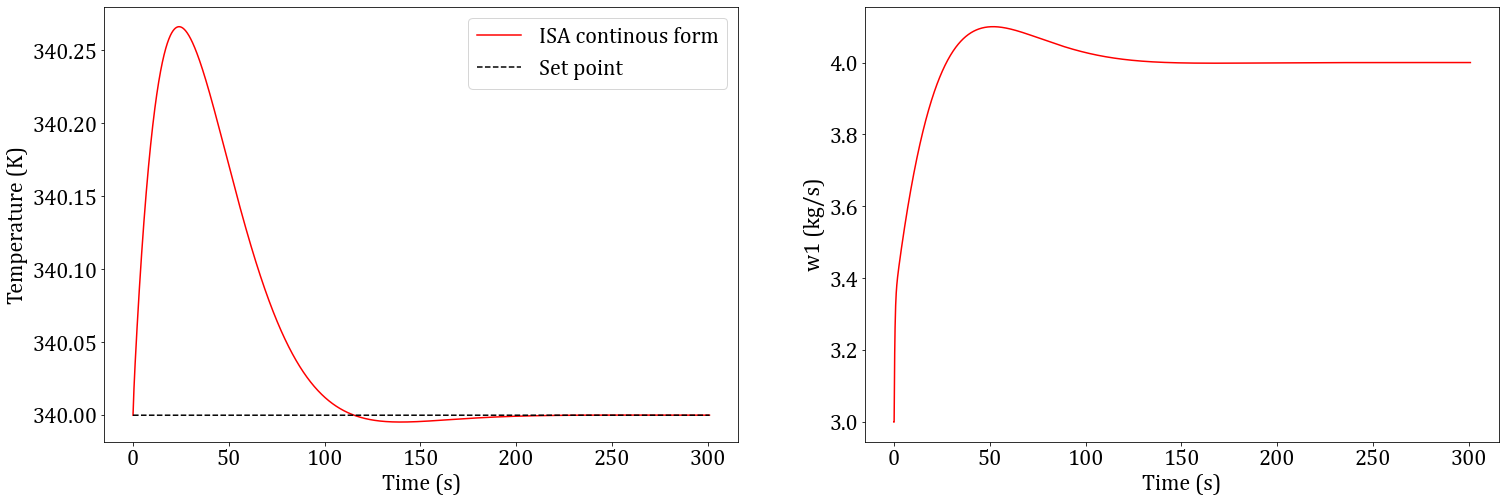

In [30]:
T3_continuous, w1_continuous = continuous_controller_sim()
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(25, 8))
ax1.plot(t, T3_continuous, 'r', label='ISA continous form')
ax1.plot(t, list(map(Ysp_setpoint, t)), 'k', linestyle='dashed', label='Set point')
ax1.set_ylabel('Temperature (K)')
ax1.set_xlabel('Time (s)')
ax1.legend()
ax2.plot(t, w1_continuous, 'r')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('w1 (kg/s)')

## Discrete PID

In [31]:
tspan = numpy.arange(0, t_end, discrete_integration_time)
initial = numpy.append(numpy.array(x0), numpy.array(3))

In [32]:
def w1_controller_positional(dt, sat_limits, e_hist, e_sum):  # <--- deals with the controller outputs/controller equations
    ei2, ei1, ei = e_hist
    p = 3 + Kc_cc*(ei + dt/τi_cc*e_sum + τd_cc/dt*(ei - ei1))
        
    # saturation
    if (p < sat_limits[0]):
        p = sat_limits[0]
    elif (p > sat_limits[1]):
        p = sat_limits[1]
    return p

def w1_controller_velocity(dt, w1, sat_limits, e_hist):  # <--- deals with the controller outputs/controller equations
    ei2, ei1, ei = e_hist
    p = w1 + Kc_cc*((ei - ei1) + dt/τi_cc*ei + τd_cc/dt*(ei - 2*ei1 + ei2))
        
    # saturation
    if (p < sat_limits[0]):
        p = sat_limits[0]
    elif (p > sat_limits[1]):
        p = sat_limits[1]
    return p
    
def discrete_controller_sim(tspan, initial, sampling_interval, sat_limits, form='positional', rw=False): # <--- euler loop for controller simulation (cont_id is the type of controller, 'P'/'PI'/'PID').
    dt = tspan[1]
    T3, w1 = initial
    w1 = 3
    T3_list, w1_list = [T3], [w1]
    e_hist = deque([0, 0, 0], maxlen=3)
    e_sum = 0
    for i, t in enumerate(tspan):
        if (i != 0):
            # error and controller
            if (i % sampling_interval) == 0: # measure and get new controller input every [sampling_interval] iterations
                e = Ysp_setpoint(t) - T3
                e_hist.append(e)
                if (rw == True):
                    if (w1 != sat_limits[0]) and (w1 != sat_limits[1]): # anti-reset windup for positional
                        e_sum += e
                else:
                    e_sum += e
                    
                if (form == 'positional'):
                    w1 = w1_controller_positional(dt, sat_limits, e_hist, e_sum)
                elif (form == 'velocity'):
                    w1 = w1_controller_velocity(dt, w1, sat_limits, e_hist)
                elif (form == 'none'):
                    w1 = 3
            # the remainder of the system
            w3 = w1 + w2
            dT3dt = 1/(ρ*V)*(w1*T1+w2*DV_T2(t)-w3*T3)
            T3 = T3 + dT3dt*dt

            T3_list.append(T3)
            w1_list.append(w1)   
    return T3_list, w1_list

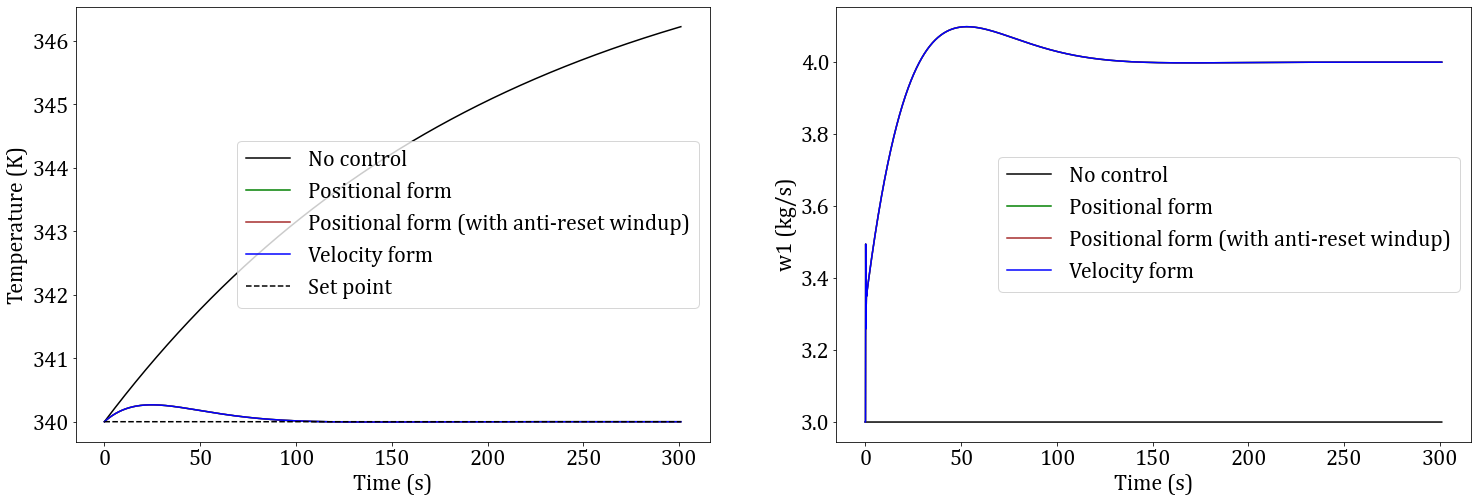

In [33]:
T3_discrete_none, w1_discrete_none = discrete_controller_sim(tspan, initial, sampling_interval, (0, 10), form='none')
T3_discrete_pos, w1_discrete_pos = discrete_controller_sim(tspan, initial, sampling_interval, (0, 10), form='positional')
T3_discrete_pos_rw, w1_discrete_pos_rw = discrete_controller_sim(tspan, initial, sampling_interval, (0, 10), form='positional', rw=True)
T3_discrete_vel, w1_discrete_vel = discrete_controller_sim(tspan, initial, sampling_interval, (0, 10), form='velocity')

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(25, 8))
ax1.plot(tspan, T3_discrete_none, 'k', label='No control')
ax1.plot(tspan, T3_discrete_pos, 'g', label='Positional form')
ax1.plot(tspan, T3_discrete_pos_rw, 'brown', label='Positional form (with anti-reset windup)')
ax1.plot(tspan, T3_discrete_vel, 'b', label='Velocity form')
ax1.plot(tspan, list(map(Ysp_setpoint, tspan)), 'k', linestyle='dashed', label='Set point')
ax1.set_ylabel('Temperature (K)')
ax1.set_xlabel('Time (s)')
ax1.legend()
ax2.plot(tspan, w1_discrete_none, 'k', label='No control')
ax2.plot(tspan, w1_discrete_pos, 'g', label='Positional form')
ax2.plot(tspan, w1_discrete_pos_rw, 'brown', label='Positional form (with anti-reset windup)')
ax2.plot(tspan, w1_discrete_vel, 'b', label='Velocity form')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('w1 (kg/s)')
ax2.legend()

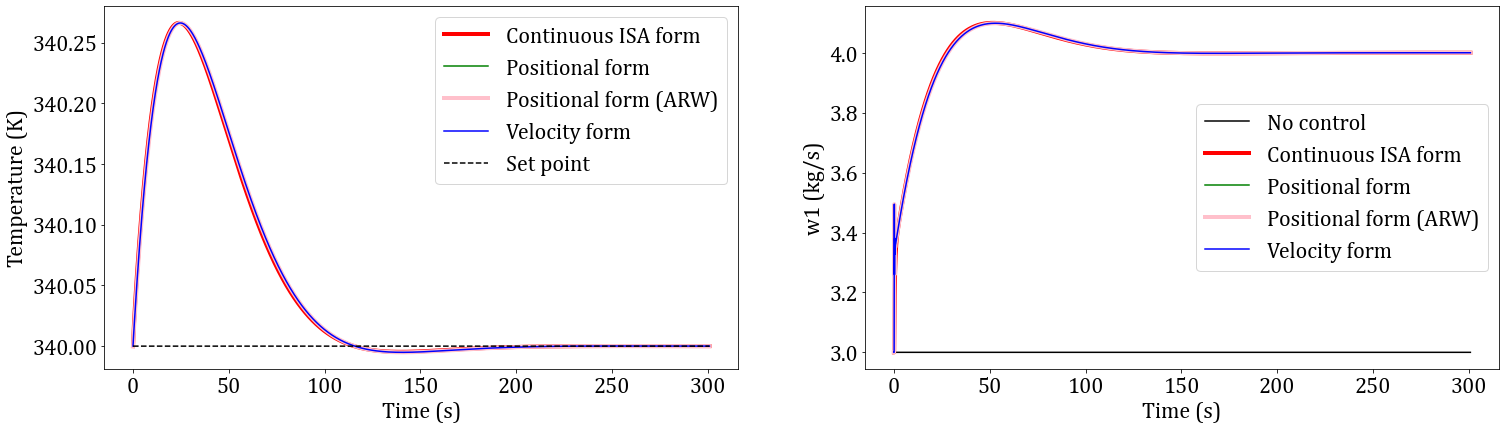

In [34]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(30/1.2, 8/1.2))
#fig, ax1 = plt.subplots(1, 1, figsize=(30/1.2/2, 8/1.2))
#ax1.plot(tspan, T3_discrete_none, 'k', label='No control')
ax1.plot(t, T3_continuous, 'r', linewidth=4, label='Continuous ISA form')
ax1.plot(tspan, T3_discrete_pos, 'g', label='Positional form')
ax1.plot(tspan, T3_discrete_pos_rw, 'pink', linewidth=4, label='Positional form (ARW)')
ax1.plot(tspan, T3_discrete_vel, 'b', label='Velocity form')
ax1.plot(tspan, list(map(Ysp_setpoint, tspan)), 'k', linestyle='dashed', label='Set point')
ax1.set_ylabel('Temperature (K)')
#ax1.set_ylim(339, 340.4)
ax1.set_xlabel('Time (s)')
ax1.legend()
ax2.plot(tspan, w1_discrete_none, 'k', label='No control')
ax2.plot(t, w1_continuous, 'r', linewidth=4, label='Continuous ISA form')
ax2.plot(tspan, w1_discrete_pos, 'g', label='Positional form')
ax2.plot(tspan, w1_discrete_pos_rw, 'pink', linewidth=4, label='Positional form (ARW)')
ax2.plot(tspan, w1_discrete_vel, 'b', label='Velocity form')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('w1 (kg/s)')
ax2.legend()

#fig.savefig('cont_1disc_0.05dv.svg')

## Effect of various sampling intervals

In [35]:
sampling_intervals = [1, 2, 3, 4, 5]
τd_cc = 2

In [36]:
# continous - DV step
def DV_T2(t): # this is your disturbance variable 
    
    if t < 0:
        return 400
    
    if t >= 0:
        return 400 + 0.05*(400) 
    
def Ysp_setpoint(t): #setpoint as a function of time 
    
    if t<0:
        return 340
    
    if t>=0:
        return 340
T3_continuous_dv, w1_continuous_dv = continuous_controller_sim()    

# continous - SP step
def DV_T2(t): # this is your disturbance variable 
    
    if t < 0:
        return 400
    
    if t >= 0:
        return 400  
    
def Ysp_setpoint(t): #setpoint as a function of time 
    
    if t<0:
        return 340
    
    if t>=0:
        return 340 + 0.05*(340)
T3_continuous_sp, w1_continuous_sp = continuous_controller_sim()

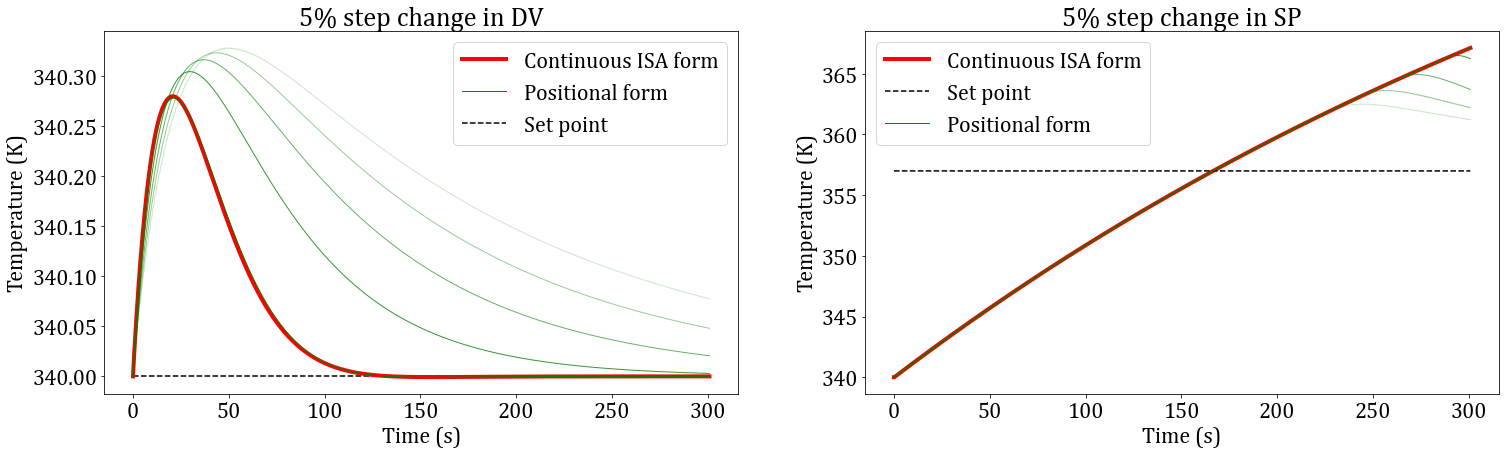

In [37]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(30/1.2, 8/1.2))
ax1.plot(t, T3_continuous_dv, 'r', linewidth=4, label='Continuous ISA form')
ax2.plot(t, T3_continuous_sp, 'r', linewidth=4, label='Continuous ISA form')
ax1.hlines(340, 0, t[-1], 'k', linestyle='dashed', label='Set point')
ax2.plot(t, list(map(Ysp_setpoint, t)), 'k', linestyle='dashed', label='Set point')

# discrete - DV step for various sampling times
def DV_T2(t): # this is your disturbance variable 
    
    if t < 0:
        return 400
    
    if t >= 0:
        return 400 + 0.05*(400) 
    
def Ysp_setpoint(t): #setpoint as a function of time 
    
    if t<0:
        return 340
    
    if t>=0:
        return 340

alpha_plot = 1
for sampling_interval in sampling_intervals:  
    T3_discrete_pos, w1_discrete_pos = discrete_controller_sim(tspan, initial, sampling_interval, (0, 10),  form='positional') 
    T3_discrete_vel, w1_discrete_vel = discrete_controller_sim(tspan, initial, sampling_interval, (0, 10), form='velocity')
    if (alpha_plot==1):
        ax1.plot(tspan, T3_discrete_pos, 'g', linewidth=1, label='Positional form')
        #ax1.plot(tspan, T3_discrete_vel, 'b', linewidth=1, label='Velocity form')   
    else:
        ax1.plot(tspan, T3_discrete_pos, 'g', linewidth=1, alpha=alpha_plot)
       # ax1.plot(tspan, T3_discrete_vel, 'b', linewidth=1, alpha=alpha_plot)
    alpha_plot -= 0.2

# discrete - SP step for various sampling times
def DV_T2(t): # this is your disturbance variable 
    
    if t < 0:
        return 400
    
    if t >= 0:
        return 400  
    
def Ysp_setpoint(t): #setpoint as a function of time 
    
    if t<0:
        return 340
    
    if t>=0:
        return 340 + 0.05*(340)

alpha_plot = 1
for sampling_interval in sampling_intervals:  
    T3_discrete_pos, w1_discrete_pos = discrete_controller_sim(tspan, initial, sampling_interval, (0, 10),  form='positional') 
    T3_discrete_vel, w1_discrete_vel = discrete_controller_sim(tspan, initial, sampling_interval, (0, 10), form='velocity')
    if (alpha_plot==1):
        ax2.plot(tspan, T3_discrete_pos, 'g', linewidth=1, label='Positional form')
        #ax1.plot(tspan, T3_discrete_vel, 'b', linewidth=1, label='Velocity form')   
    else:
        ax2.plot(tspan, T3_discrete_pos, 'g', linewidth=1, alpha=alpha_plot)
       # ax1.plot(tspan, T3_discrete_vel, 'b', linewidth=1, alpha=alpha_plot)
    alpha_plot -= 0.2
    
ax1.set_title('5% step change in DV')
ax1.set_ylabel('Temperature (K)')
ax1.set_xlabel('Time (s)')
ax1.legend()
ax2.set_title('5% step change in SP')
ax2.set_ylabel('Temperature (K)')
ax2.set_xlabel('Time (s)')
ax2.legend()

#plt.savefig('sampling_times_0.05.svg')   

# IMC controller

## Tuning

In [38]:
# IMC controller as a rational polynomial
r = 1

sp.var('s, τc, Km, τm')
Gm = Km/(τm*s + 1)
f = 1/(τc*s + 1)**r
Gc_imc = f/Gm
Gc_imc

(s*τm + 1)/(Km*(s*τc + 1))

In [39]:
# controller parameters tested
τcs = numpy.linspace(0.01*τm_fit, τm_fit, 5)

In [40]:
# controller and internal model
def imc_controller(Km, τm, τc):
    Gc_asterisk = scipy.signal.lti([τm, 1], [Km*τc, Km]).to_ss() # r = 1
    return Gc_asterisk

In [41]:
def intsys(t,x, MV_w1):
    
    T3 = x
    
    w3 = MV_w1 + w2
    dT3dt = 1/(ρ*V)*(MV_w1*T1+w2*DV_T2(t)-w3*T3) # notice i changed MV_w1(t) to a global variable
    
    return dT3dt

In [42]:
def imc_controller_sim():
    MV_w1 = 3
    dt = t[1]-t[0]
    k = numpy.linspace(0,dt,100)

    results = []
    MV_s = []
    
    Gc_asterisk = imc_controller(Km_fit, τm_fit, τc)
    G_tilde = scipy.signal.lti([Km_fit], [τm_fit, 1]).to_ss()
    xc = numpy.zeros([Gc_asterisk.A.shape[0], 1])
    xm = numpy.zeros([G_tilde.A.shape[0], 1])

    # initial state
    system = x0[0] #initial state
    T3_tilde_pr = (G_tilde.C.dot(xm) + G_tilde.D.dot(MV_w1))[0, 0]

    for count, time in enumerate(t):

        results.append(system)
        MV_s.append(MV_w1)

        T3sp_pr = Ysp_setpoint(time) - x0[0]  #temperature setpoint in deviation form
        T3_pr = results[count] - x0[0] # actual temperature in deviation form
        error = T3sp_pr - (T3_pr - T3_tilde_pr) # error calculation in deviation form
        system = system + intsys(time,results[count], MV_w1)*dt # system response to MV

        if numpy.abs(error) >0:

            for i in k: #fast integration loop for controller implementation between 0 and dt 'continuous controller output'
                stepz = k[1] - k[0] 
                dxcdt = Gc_asterisk.A.dot(xc) + Gc_asterisk.B.dot(error)
                MV_w1_pr = (Gc_asterisk.C.dot(xc) + Gc_asterisk.D.dot(error))[0, 0]
                MV_w1 = MV_w1_pr + 3  #adding bias - bias might not be equal to initial MV, what is the effect of different bias?

                if MV_w1 <0: #output limits
                    MV_w1 = 0

                if MV_w1 > 10:
                    MV_w1 = 10

                xc = xc + dxcdt*stepz

        dxmdt = G_tilde.A.dot(xm) + G_tilde.B.dot(MV_w1 - 3)
        T3_tilde_pr = (G_tilde.C.dot(xm) + G_tilde.D.dot(MV_w1 - 3))[0, 0]
        xm = xm + dxmdt*dt
    return results, MV_s

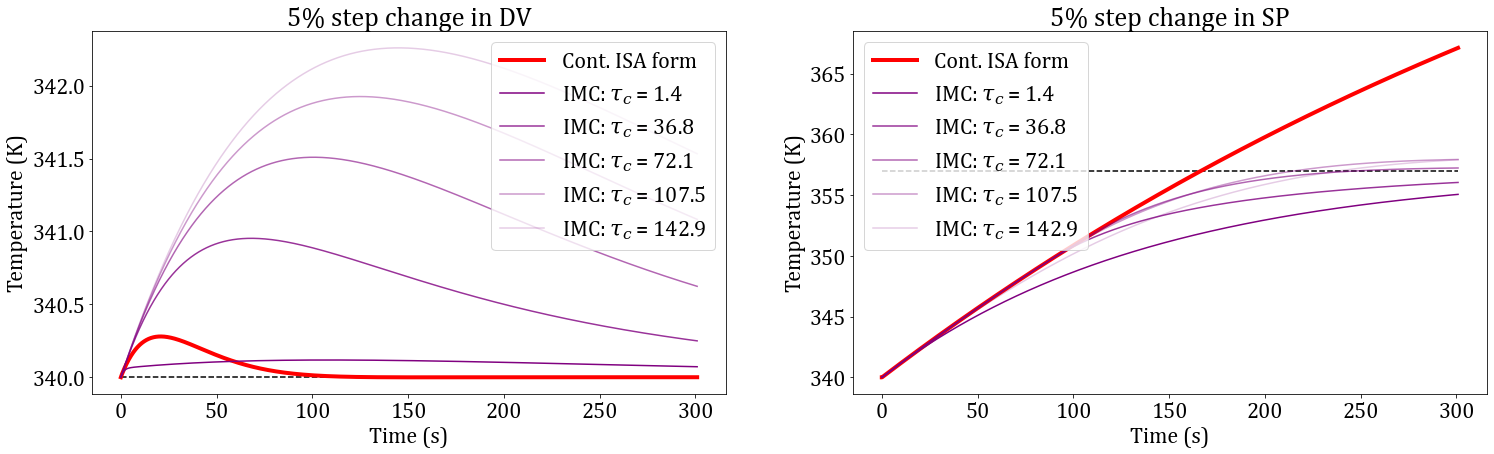

In [43]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(30/1.2, 8/1.2))
ax1.hlines(340, 0, t_end, 'k', linestyle='dashed')
ax2.hlines(340 + 0.05*(340), 0, t_end, 'k', linestyle='dashed')
ax1.set_ylabel('Temperature (K)')
ax1.set_xlabel('Time (s)')
ax1.set_title('5% step change in DV')
ax2.set_ylabel('Temperature (K)')
ax2.set_xlabel('Time (s)')
ax2.set_title('5% step change in SP')
ax1.plot(t, T3_continuous_dv, 'r', linewidth=4, label='Cont. ISA form')
ax2.plot(t, T3_continuous_sp, 'r', linewidth=4, label='Cont. ISA form')


alpha_plot = 1
for τc in τcs:
    def DV_T2(t): # this is your disturbance variable  
        if t < 0:
            return 400
        if t >= 0:
            return 400 + 0.05*400  
    def Ysp_setpoint(t): #setpoint as a function of time    
        if t<0:
            return 340
        if t>=0:
            return 340
    T3_imc, w1_imc = imc_controller_sim()
    ax1.plot(t, T3_imc, 'purple', label=f'IMC: $τ_c$ = {round(τc, 1)}', alpha=alpha_plot)
    
    def DV_T2(t): # this is your disturbance variable  
        if t < 0:
            return 400
        if t >= 0:
            return 400
    def Ysp_setpoint(t): #setpoint as a function of time    
        if t<0:
            return 340
        if t>=0:
            return 340 + 0.05*340
    T3_imc, w1_imc = imc_controller_sim()
    ax2.plot(t, T3_imc, 'purple', label=f'IMC: $τ_c$ = {round(τc, 1)}', alpha=alpha_plot)
    alpha_plot -= 0.2
ax1.legend()
ax2.legend()
plt.savefig('imc_tuning.svg')

# Effect of non-linearities

In [44]:
def DV_T2(t): # this is your disturbance variable 
    
    if t < 0:
        return 400
    
    if t >= 0:
        return 400 
    
def Ysp_setpoint(t): #setpoint as a function of time 
    
    if t<0:
        return 340
    
    if (t>=0) and (t<600):
        return 340 + 0.05*340
    
    if (t>=600):
        return 340 + 0.05*340 + 0.05*340

continuous_integration_time = 0.1

discrete_integration_time = 0.1
sampling_interval = 2

t_end = 1351

In [45]:
# continuous
α = (0.05 + 0.2)/2
t = numpy.arange(0, t_end, continuous_integration_time) #adjust for sampling 
T3_continuous, w1_continuous = continuous_controller_sim()

In [46]:
# discrete 
tspan = numpy.arange(0, t_end, discrete_integration_time)
initial = numpy.append(numpy.array(x0), numpy.array(3))
T3_discrete_pos, w1_discrete_pos = discrete_controller_sim(tspan, initial, sampling_interval, (0, 10),  form='positional')
T3_discrete_vel, w1_discrete_vel = discrete_controller_sim(tspan, initial, sampling_interval, (0, 10),  form='velocity')

In [47]:
# IMC
τc = 72.1
T3_imc, w1_imc = imc_controller_sim()

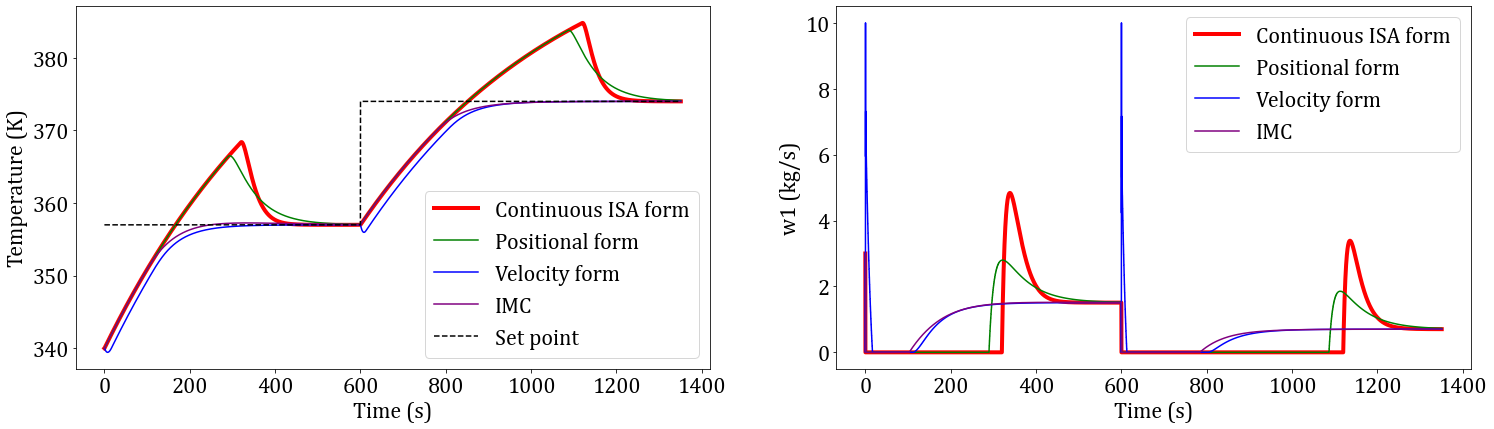

In [48]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(30/1.2, 8/1.2))
ax1.plot(t, T3_continuous, 'r', linewidth=4, label='Continuous ISA form')
ax1.plot(tspan, T3_discrete_pos, 'g', label='Positional form')
ax1.plot(tspan, T3_discrete_vel, 'b', label='Velocity form')
ax1.plot(t, T3_imc, 'purple', label='IMC')
ax1.plot(tspan, list(map(Ysp_setpoint, tspan)), 'k', linestyle='dashed', label='Set point')
ax1.set_ylabel('Temperature (K)')
#ax1.set_ylim(339, 340.4)
ax1.set_xlabel('Time (s)')
ax1.legend()

ax2.plot(t, w1_continuous, 'r', linewidth=4, label='Continuous ISA form')
ax2.plot(tspan, w1_discrete_pos, 'g', label='Positional form')
ax2.plot(tspan, w1_discrete_vel, 'b', label='Velocity form')
ax2.plot(t, w1_imc, 'purple', label='IMC')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('w1 (kg/s)')
ax2.legend()
plt.savefig('linearity.svg')

# Noise

In [49]:
continuous_integration_time = 0.1

discrete_integration_time = 0.1
sampling_interval = 2
noise_sd = 1

t_end = 1001

In [50]:
tspan = numpy.arange(0, t_end, discrete_integration_time)
initial = numpy.append(numpy.array(x0), numpy.array(3))

t = numpy.arange(0, t_end, continuous_integration_time)

In [51]:
def imc_controller_with_noise_sim():
    MV_w1 = 3
    dt = t[1]-t[0]
    k = numpy.linspace(0,dt,100)

    results = []
    MV_s = []
    
    Gc_asterisk = imc_controller(Km_fit, τm_fit, τc)
    G_tilde = scipy.signal.lti([Km_fit], [τm_fit, 1]).to_ss()
    xc = numpy.zeros([Gc_asterisk.A.shape[0], 1])
    xm = numpy.zeros([G_tilde.A.shape[0], 1])

    # initial state
    system = numpy.array(x0) #initial state
    T3_tilde_pr = (G_tilde.C.dot(xm) + G_tilde.D.dot(MV_w1))[0, 0]

    for count, time in enumerate(t):

        results.append(system)
        MV_s.append(MV_w1)

        T3sp_pr = Ysp_setpoint(time) - x0[0]  #temperature setpoint in deviation form
        T3_pr = results[count][0] - x0[0] # actual temperature in deviation form
        error = T3sp_pr - (T3_pr + numpy.random.normal(0, noise_sd) - T3_tilde_pr)  # error calculation in deviation form
        system = system + intsys(time,results[count], MV_w1)*dt # system response to MV

        if numpy.abs(error) >0:

            for i in k: #fast integration loop for controller implementation between 0 and dt 'continuous controller output'
                stepz = k[1] - k[0] 
                dxcdt = Gc_asterisk.A.dot(xc) + Gc_asterisk.B.dot(error)
                MV_w1_pr = (Gc_asterisk.C.dot(xc) + Gc_asterisk.D.dot(error))[0, 0]
                MV_w1 = MV_w1_pr + 3  #adding bias - bias might not be equal to initial MV, what is the effect of different bias?

                if MV_w1 <0: #output limits
                    MV_w1 = 0

                if MV_w1 > 10:
                    MV_w1 = 10

                xc = xc + dxcdt*stepz

        dxmdt = G_tilde.A.dot(xm) + G_tilde.B.dot(MV_w1 - 3)
        T3_tilde_pr = (G_tilde.C.dot(xm) + G_tilde.D.dot(MV_w1 - 3))[0, 0]
        xm = xm + dxmdt*dt
    return results, MV_s

def discrete_controller_with_noise_sim(tspan, initial, sampling_interval, sat_limits, form='positional', rw=False): # <--- euler loop for controller simulation (cont_id is the type of controller, 'P'/'PI'/'PID').
    dt = tspan[1]
    T3, w1 = initial
    w1 = 3
    T3_list, w1_list = [T3], [w1]
    e_hist = deque([0, 0, 0], maxlen=3)
    e_sum = 0
    for i, t in enumerate(tspan):
        if (i != 0):
            # error and controller
            if (i % sampling_interval) == 0: # measure and get new controller input every [sampling_interval] iterations
                e = Ysp_setpoint(t) - T3 + numpy.random.normal(0, noise_sd)
                e_hist.append(e)
                if (rw == True):
                    if (w1 != sat_limits[0]) and (w1 != sat_limits[1]): # anti-reset windup for positional
                        e_sum += e
                else:
                    e_sum += e
                    
                if (form == 'positional'):
                    w1 = w1_controller_positional(dt, sat_limits, e_hist, e_sum)
                elif (form == 'velocity'):
                    w1 = w1_controller_velocity(dt, w1, sat_limits, e_hist)
                elif (form == 'none'):
                    w1 = 3
            # the remainder of the system
            w3 = w1 + w2
            dT3dt = 1/(ρ*V)*(w1*T1+w2*DV_T2(t)-w3*T3)
            T3 = T3 + dT3dt*dt

            T3_list.append(T3)
            w1_list.append(w1)   
    return T3_list, w1_list

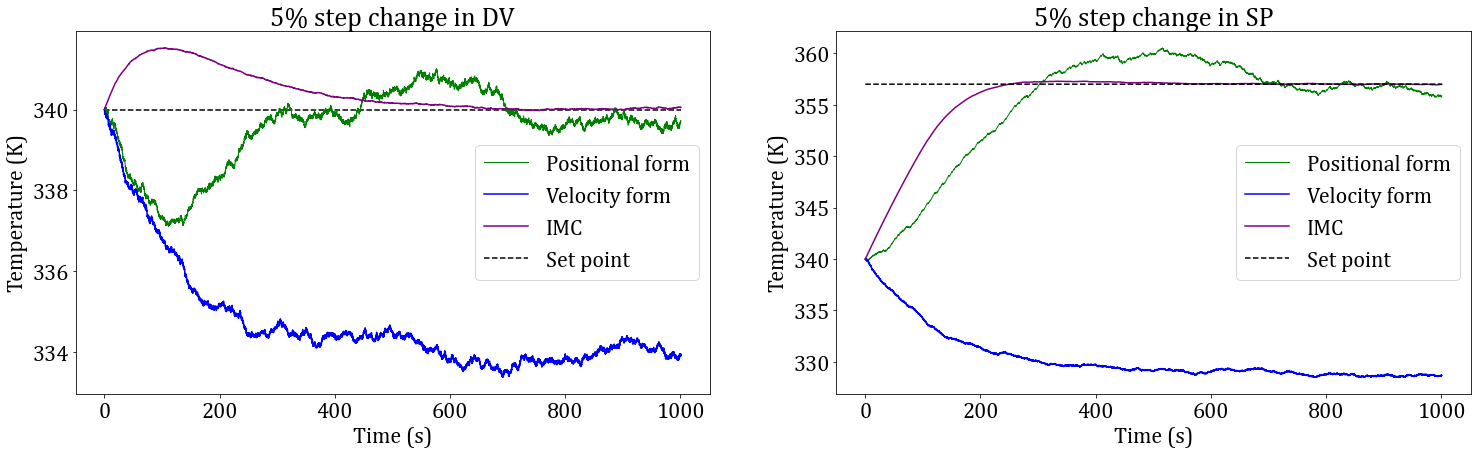

In [52]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(30/1.2, 8/1.2))

# DV change
def DV_T2(t): # this is your disturbance variable  
    if t < 0:
        return 400
    if t >= 0:
        return 400 + 0.05*400  
def Ysp_setpoint(t): #setpoint as a function of time    
    if t<0:
        return 340
    if t>=0:
        return 340

T3_discrete_pos, w1_discrete_pos = discrete_controller_with_noise_sim(tspan, initial, sampling_interval, (0, 10), form='positional')
T3_discrete_vel, w1_discrete_vel = discrete_controller_with_noise_sim(tspan, initial, sampling_interval, (0, 10), form='velocity')
T3_imc, w1_imc = imc_controller_with_noise_sim()

ax1.plot(tspan, T3_discrete_pos, 'g', linewidth=1, label='Positional form')
ax1.plot(tspan, T3_discrete_vel, 'b', label='Velocity form')
ax1.plot(t, T3_imc, 'purple', label='IMC')
# SP change
def DV_T2(t): # this is your disturbance variable  
    if t < 0:
        return 400
    if t >= 0:
        return 400  
def Ysp_setpoint(t): #setpoint as a function of time    
    if t<0:
        return 340
    if t>=0:
        return 340 + 0.05*340
T3_discrete_pos, w1_discrete_pos = discrete_controller_with_noise_sim(tspan, initial, sampling_interval, (0, 10), form='positional')
T3_discrete_vel, w1_discrete_vel = discrete_controller_with_noise_sim(tspan, initial, sampling_interval, (0, 10), form='velocity')
T3_imc, w1_imc = imc_controller_with_noise_sim()

ax2.plot(tspan, T3_discrete_pos, 'g', linewidth=1, label='Positional form')
ax2.plot(tspan, T3_discrete_vel, 'b', label='Velocity form')
ax2.plot(t, T3_imc, 'purple', label='IMC')

ax1.hlines(340, 0, t[-1], 'k', linestyle='dashed', label='Set point')
ax1.set_title('5% step change in DV')
ax1.set_ylabel('Temperature (K)')
ax1.set_xlabel('Time (s)')
ax1.legend()

ax2.plot(t, list(map(Ysp_setpoint, t)), 'k', linestyle='dashed', label='Set point')
ax2.set_title('5% step change in SP')
ax2.set_ylabel('Temperature (K)')
ax2.set_xlabel('Time (s)')
ax2.legend()

#fig.savefig('noise.svg')

# Performance

In [167]:
continuous_integration_time = 0.1

discrete_integration_time = 0.1
sampling_interval = 2
noise_sd = 1

t_end = 1001

In [168]:
tspan = numpy.arange(0, t_end, discrete_integration_time)
initial = numpy.append(numpy.array(x0), numpy.array(3))

t = numpy.arange(0, t_end, continuous_integration_time)

In [177]:
def evaluate_performance(tspan, T3):
    T3_sp = numpy.array(list(map(Ysp_setpoint, tspan)))
    function = tspan*abs(T3 - T3_sp)
    itae = scipy.integrate.trapz(function, x=tspan)
    
    if (Ysp_setpoint(0) != Ysp_setpoint(-1)):
        overshoot = (max(T3) - Ysp_setpoint(0))/(Ysp_setpoint(0) - Ysp_setpoint(-1))*100
    else:
        overshoot = None
    
    rise_time = None
    for i, t in enumerate(tspan):
        if (i != 0):
            if (T3[i] > Ysp_setpoint(0)):
                sign = -1
            elif (T3[i] < Ysp_setpoint(0)):
                sign = 1

            if (i != 1):
                if (prev_sign != sign):
                    rise_time = t
                    break
            prev_sign = sign
    return [itae, overshoot, rise_time]

5% step change in DV


,Controller,ITAE,Overshoot,Rise time
0,Continuous,509.887350,None,135.3
1,Positional form,2036.787495,None,NaN
2,Positional form (ARW),2036.787495,None,NaN
3,Velocity form,2036.787495,None,NaN
4,IMC,85095.096353,None,NaN


5% step change in SP


,Controller,ITAE,Overshoot,Rise time
0,Continuous,456994.295032,6.704891e+01,166.7
1,Positional form,464042.409206,5.595666e+01,166.7
2,Positional form (ARW),77477.701610,-5.304859e-07,NaN
3,Velocity form,128038.042857,-4.335757e-06,NaN
4,IMC,113589.404031,1.536935e+00,248.5


Kc_cc:-2.3770833334687422, τi_cc: 33.7474119176533, τd_cc:33.7474119176533, α: 0.125, sampling_interval: 2, τc: 72.1


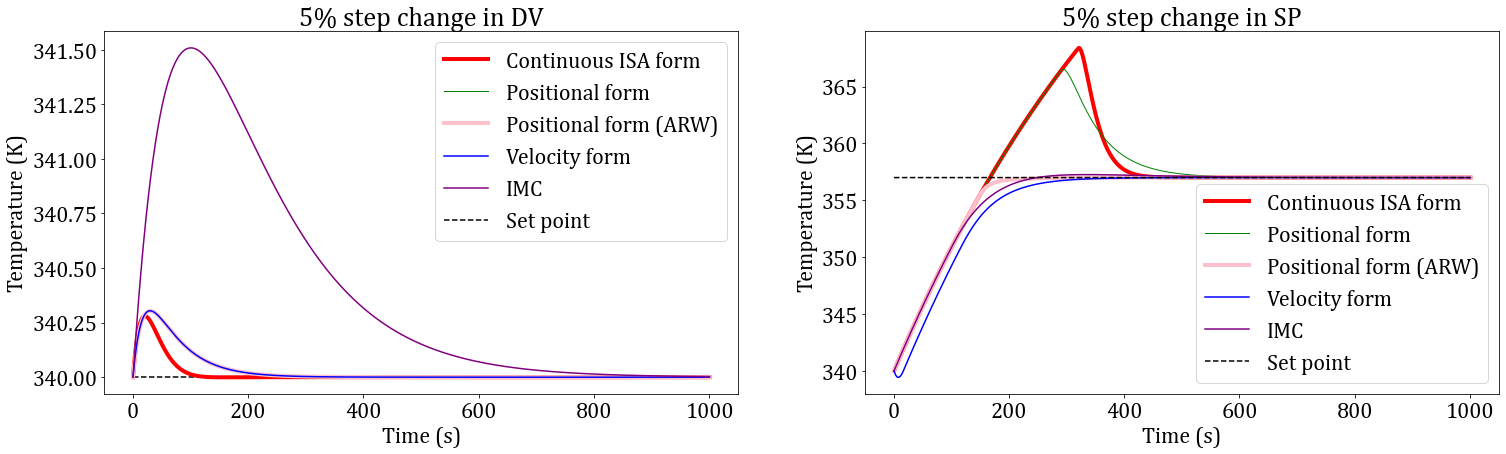

In [178]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(30/1.2, 8/1.2))

# DV change
def DV_T2(t): # this is your disturbance variable  
    if t < 0:
        return 400
    if t >= 0:
        return 400 + 0.05*400  
def Ysp_setpoint(t): #setpoint as a function of time    
    if t<0:
        return 340
    if t>=0:
        return 340
T3_continuous, w1_continuous = continuous_controller_sim()
T3_discrete_pos, w1_discrete_pos = discrete_controller_sim(tspan, initial, sampling_interval, (0, 10), form='positional')
T3_discrete_pos_rw, w1_discrete_pos_rw = discrete_controller_sim(tspan, initial, sampling_interval, (0, 10), form='positional', rw=True)
T3_discrete_vel, w1_discrete_vel = discrete_controller_sim(tspan, initial, sampling_interval, (0, 10), form='velocity')
T3_imc, w1_imc = imc_controller_sim()

performance_results = []
performance_results.append(['Continuous'] + evaluate_performance(t, T3_continuous))
performance_results.append(['Positional form'] + evaluate_performance(tspan, T3_discrete_pos))
performance_results.append(['Positional form (ARW)'] + evaluate_performance(tspan, T3_discrete_pos_rw))
performance_results.append(['Velocity form'] + evaluate_performance(tspan, T3_discrete_vel))
performance_results.append(['IMC'] + evaluate_performance(t, T3_imc))
df = pd.DataFrame(data=performance_results, columns=['Controller', 'ITAE', 'Overshoot', 'Rise time'])
print('5% step change in DV')
display(df)

ax1.plot(t, T3_continuous, 'r', linewidth=4, label='Continuous ISA form')
ax1.plot(tspan, T3_discrete_pos, 'g', linewidth=1, label='Positional form')
ax1.plot(tspan, T3_discrete_pos_rw, 'pink', linewidth=4, label='Positional form (ARW)')
ax1.plot(tspan, T3_discrete_vel, 'b', label='Velocity form')
ax1.plot(t, T3_imc, 'purple', label='IMC')

# SP change
def DV_T2(t): # this is your disturbance variable  
    if t < 0:
        return 400
    if t >= 0:
        return 400  
def Ysp_setpoint(t): #setpoint as a function of time    
    if t<0:
        return 340
    if t>=0:
        return 340 + 0.05*340
T3_continuous, w1_continuous = continuous_controller_sim()
T3_discrete_pos, w1_discrete_pos = discrete_controller_sim(tspan, initial, sampling_interval, (0, 10), form='positional')
T3_discrete_pos_rw, w1_discrete_pos_rw = discrete_controller_sim(tspan, initial, sampling_interval, (0, 10), form='positional', rw=True)
T3_discrete_vel, w1_discrete_vel = discrete_controller_sim(tspan, initial, sampling_interval, (0, 10), form='velocity')
T3_imc, w1_imc = imc_controller_sim()

performance_results = []
performance_results.append(['Continuous'] + evaluate_performance(t, T3_continuous))
performance_results.append(['Positional form'] + evaluate_performance(tspan, T3_discrete_pos))
performance_results.append(['Positional form (ARW)'] + evaluate_performance(tspan, T3_discrete_pos_rw))
performance_results.append(['Velocity form'] + evaluate_performance(tspan, T3_discrete_vel))
performance_results.append(['IMC'] + evaluate_performance(t, T3_imc))
df = pd.DataFrame(data=performance_results, columns=['Controller', 'ITAE', 'Overshoot', 'Rise time'])
print('5% step change in SP')
display(df)

ax2.plot(t, T3_continuous, 'r', linewidth=4, label='Continuous ISA form')
ax2.plot(tspan, T3_discrete_pos, 'g', linewidth=1, label='Positional form')
ax2.plot(tspan, T3_discrete_pos_rw, 'pink', linewidth=4, label='Positional form (ARW)')
ax2.plot(tspan, T3_discrete_vel, 'b', label='Velocity form')
ax2.plot(t, T3_imc, 'purple', label='IMC')

ax1.hlines(340, 0, t[-1], 'k', linestyle='dashed', label='Set point')
ax1.set_title('5% step change in DV')
ax1.set_ylabel('Temperature (K)')
ax1.set_xlabel('Time (s)')
ax1.legend()

ax2.plot(t, list(map(Ysp_setpoint, t)), 'k', linestyle='dashed', label='Set point')
ax2.set_title('5% step change in SP')
ax2.set_ylabel('Temperature (K)')
ax2.set_xlabel('Time (s)')
ax2.legend()

#fig.savefig('final.svg')
print(f'Kc_cc:{Kc_cc}, τi_cc: {τi_cc}, τd_cc:{τi_cc}, α: {α}, sampling_interval: {sampling_interval}, τc: {τc}')

# Controller bias

In [226]:
continuous_integration_time = 0.1
biases = [1, 2 ,3 ,4, 5]

t_end_dv = 151
t_end_sp = 501

In [227]:
initial = numpy.append(numpy.array(x0), numpy.array(3))

In [228]:
def continuous_controller_bias_test_sim(bias):
    MV_w1 = 3
    dt = t[1]-t[0]
    k = numpy.linspace(0,dt,100)
    system = x0[0] #initial state 
    results = []
    MV_s = []
    Gss = cont_controller(Kc_cc, τi_cc, τd_cc, α)
    xc = numpy.zeros([Gss.A.shape[0],1]) #ss A matrix

    for count, time in enumerate(t):

        results.append(system)
        MV_s.append(MV_w1)

        T3sp = Ysp_setpoint(time) #temperature setpoint 
        error = T3sp - results[count] #error calculation

        system = system + intsys(time,results[count], MV_w1)*dt #system response to MV

        if numpy.abs(error) >0:

            for i in k: #fast integration loop for controller implementation between 0 and dt 'continuous controller output'
                stepz = k[1] - k[0] 
                dxcdt = Gss.A.dot(xc)+Gss.B.dot(error)
                MV_w1 = Gss.C.dot(xc) + Gss.D.dot(error)
                MV_w1 = MV_w1[0,0] + bias  #adding bias - bias might not be equal to initial MV, what is the effect of different bias?

                if MV_w1 <0: #output limits
                    MV_w1 = 0

                if MV_w1 > 10:
                    MV_w1 = 10

                xc = xc + dxcdt*stepz

    T3_continuous = results
    w1_continuous = MV_s
    return [T3_continuous, w1_continuous]

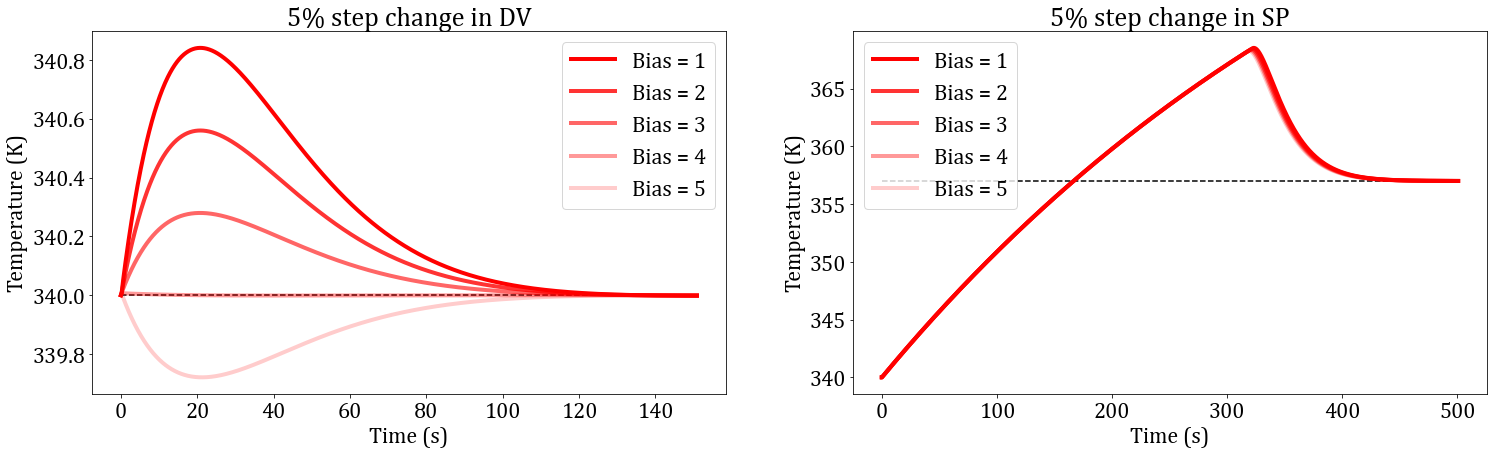

In [229]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(30/1.2, 8/1.2))
ax1.hlines(340, 0, t_end_dv, 'k', linestyle='dashed')
ax2.hlines(340 + 0.05*(340), 0, t_end_sp, 'k', linestyle='dashed')
ax1.set_ylabel('Temperature (K)')
ax1.set_xlabel('Time (s)')
ax1.set_title('5% step change in DV')
ax2.set_ylabel('Temperature (K)')
ax2.set_xlabel('Time (s)')
ax2.set_title('5% step change in SP')

alpha_plot = 1
for bias in biases:
    def DV_T2(t): # this is your disturbance variable  
        if t < 0:
            return 400
        if t >= 0:
            return 400 + 0.05*400  
    def Ysp_setpoint(t): #setpoint as a function of time    
        if t<0:
            return 340
        if t>=0:
            return 340
    t = numpy.arange(0, t_end_dv, continuous_integration_time)
    T3_continuous, w1_continuous = continuous_controller_bias_test_sim(bias)
    ax1.plot(t, T3_continuous, 'r', linewidth=4, label=f'Bias = {round(bias, 1)}', alpha=alpha_plot)
    
    
    def DV_T2(t): # this is your disturbance variable  
        if t < 0:
            return 400
        if t >= 0:
            return 400
    def Ysp_setpoint(t): #setpoint as a function of time    
        if t<0:
            return 340
        if t>=0:
            return 340 + 0.05*340
    t = numpy.arange(0, t_end_sp, continuous_integration_time)
    T3_continuous, w1_continuous = continuous_controller_bias_test_sim(bias)
    ax2.plot(t, T3_continuous, 'r', linewidth=4, label=f'Bias = {round(bias, 1)}', alpha=alpha_plot)
    alpha_plot -= 0.2
ax1.legend()
ax2.legend()
#fig.savefig('biases.svg')